
1 cortical area + 1 claustrum. Hector June 2020


# NPY and PV + STD


In [1]:
# libraries
import numpy as np
import numpy.matlib
import pandas 
import brian2
import watermark

In [2]:
#Graphic
import matplotlib.pyplot as plt
from matplotlib import cm
width_in_inches = 12
height_in_inches = 8
dots_per_inch = 70

# 1. Theory


I define the function that transforms input current to changes in firing rate for excitatory neurons (Abbott and Chance, 2005). 
<br>
$$r_E = \frac{aI_{syn,E} - b}{1 - e^{-d(aI_{syn,E} - b)}} $$

Update the firing rates of the interneurons using a threshold linear input/output function
$$ \begin{cases}
  r_I = \frac{1}{g_2}(c_II_{syn,I} - c_0) + r_0 & \text{for } r_I\ge 0\\    
  r_I = 0     & \text{otherwise }  
\end{cases} $$

In [3]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        a = parameters['a_E']
        b = parameters['b_E']
        d = parameters['d_E']
        return np.divide((a*input_current - b),(1 - np.exp(-d*(a*input_current - b))))
    if population_type == 'I':
        c_I = parameters['c_I']
        g_2 = parameters['g_2']
        r_0 = parameters['r0_I']
        c_0 = parameters['c_0']
        r = np.maximum((1/g_2)*(c_I*input_current - c_0) + r_0,0)
        return r
        # NOTE: using python broadcasting for ones subtraction, so should work for multi-area case too

Define the NMDA derivative
<br>
$$ \frac{dS_{NMDA}}{dt} = -\frac{S_{NMDA}}{\tau_{NMDA}} + (1 - S_{NMDA})\gamma r_E$$
(Wong & Wang, 2006)

In [4]:
def NMDA_deriv(S_NMDA_prev,rate_now,parameters):
    
    return -S_NMDA_prev/parameters['tau_NMDA'] + parameters['gam']*(1 - S_NMDA_prev)*rate_now

Define the GABA derivative
<br>
$$ \frac{dS_{GABA}}{dt} = -\frac{S_{GABA}}{\tau_{GABA}} + \gamma_Ir_I$$
(Wong & Wang, 2006)

In [5]:
def GABA_deriv(S_GABA_prev,rate_now,population_type,parameters):
    if population_type == 'PV':
        return -S_GABA_prev/parameters['tau_GABA'] + parameters['gammai']*rate_now
    if population_type == 'NPY':
        return -S_GABA_prev/parameters['tau_GABA_NPY'] + parameters['gammai']*rate_now

<br>
$$ \frac{dD}{dt} = -p r D + \frac{1 - D}{\tau_D}$$


$$ \frac{dS_{NMDA}^{Cla}}{dt} = p r D - \frac{S_{NMDA}^{Cla}}{\tau_{NMDA}} $$

where p: constant vesicle release probability (0.45), D: fraction of available vesicles, $\tau_D$: time constant (600mS).


(Wei & wang, 2016)

In [6]:
def D_deriv(D_prev,rate_now,parameters):
    return -parameters['p']*rate_now*D_prev +(1-D_prev)/parameters['tau_D']

In [7]:
def NMDA_cla_deriv(S_NMDA_cla_prev,rate_now,D_prev,parameters):
    return parameters['p']*rate_now*D_prev - S_NMDA_cla_prev/parameters['tau_NMDA']

# 2. Set Parameters

In [8]:
parameters = {}
parameters.update({'SF1': 0.5, # Jorge M scaling factor to keep rates in check
                    'SF2': 2})    # Jorge M scaling factor to keep rates in check
                   
parameters.update({ # Time constants
                    'tau_NMDA': 0.06   * brian2.second,    # s 
                    'tau_GABA': 0.005  * brian2.second,    # s 
                    'tau_GABA_NPY': 0.3  * brian2.second,    # s
                    'tau_AMPA': 0.002  * brian2.second,    # s 
                    'tau_rates': 0.002 * brian2.second,    # s 
                    # f-I curve parameters - E populations
                    'a_E': 270. *parameters['SF1']  * brian2.Hz/brian2.nA,  # Hz/nA
                    'b_E': 108. *parameters['SF1']  * brian2.Hz,            # Hz
                    'd_E': 0.154*parameters['SF2']  * brian2.second,        # s
                    'gam': 0.641*parameters['SF2'],                         # unitless
                    # f-I curve parameters - I populations
                    'g_2': 1/(0.5*parameters['SF1']),                    # unitless
                    'c_I': 615  * brian2.Hz/brian2.nA,                 # Hz/nA
                    'c_0': 177  * brian2.Hz,                           # Hz
                    'gammai': parameters['SF2'],                       # unitless
                    # Local connectivity matrix strengths
    
                    # Strength of connections from E cells
                    'g_E_self': 0.10 * brian2.nA ,        # nA --> I_local_grad_NMDA
                    'g_E_cross': 0.0107* brian2.nA,         # nA --> J_NMDA --> I_local_nongrad_NMDA
                    # Strength of connections from I cells
                    'g_E_I':  -0.40  * brian2.nA,         # nA --> J_GABA --> I_local_GABA
                    'g_Iself': -0.12  * brian2.nA,         # nA --> J_GABA --> I_local_GABA
                    'g_I_E': 700 * brian2.pA,               #pA
                    'g_E_I_clas': -0.31* brian2.nA,         #pA
                    # Background inputs
                    'I0_E': 0.3294     * brian2.nA,         # nA
                    'I0_I': 0.26       * brian2.nA,         # nA
                    # Noise std dev
                    'std_noise': 0.01 * brian2.nA,         # nA      
                    # initial values
                    'r0_E': 5 * brian2.Hz,
                    'r0_I': 11*parameters['SF1'] * brian2.Hz
                        })      
parameters.update({ # Zetas
                    'zeta': parameters['c_I']*parameters['g_E_I']*parameters['tau_GABA']*parameters['gammai']\
                            /(parameters['g_2'] - parameters['g_Iself']*parameters['tau_GABA']*parameters['gammai']*parameters['c_I']),
                    'zeta2': 2*parameters['c_I']*parameters['tau_GABA']*parameters['gammai']*parameters['g_E_I']\
                            /(parameters['c_I']*parameters['tau_GABA']*parameters['gammai']*parameters['g_Iself'] - parameters['g_2']),
                        })    
parameters.update({'S0': 0}) # #initial S_NMDA and S_GABA
parameters.update({'dt': 0.5 * brian2.ms}) 
parameters.update({'D_0': 1})

parameters.update({'trial_length': 3 * brian2.second,
                   'start_time': 0 *brian2.second, # s
                   'end_time': 3 *brian2.second}) 

In [9]:
parameters.update({'p_Icort_Eclas': 0.4,  # 75% percent of claustrum projection goes to inhibitory cells in the cortex, Jackson et al., Neuron, 2018 
                   'p_Iclas_Ecort' : 0.2 # 20% percent of cortical projection goes to inhibitory cells in the claustrum  (where does it come from ?)

})

parameters.update({'p': 0.45, #vesicle release probability 
                   'tau_D' : 10 * brian2.second # 20% percent of cortical projection goes to inhibitory cells in the claustrum  (where does it come from ?)

})

# 2. Connectivity

In [10]:
#plot
pops = ['E1','E2','PV','NPY']
pops_column_list  = ['from '+ mystring for mystring in pops]
pops_row_list  = ['to '+ mystring for mystring in pops]

## Cortical connectivity

In [11]:
parameters.update({'g_PV_NPY': -0.7  * brian2.nA })
parameters.update({'g_E_NPY': -0.5  * brian2.nA })

In [12]:
######## LOCAL ########
J =  np.array([[parameters['g_E_self']    , parameters['g_E_cross'], parameters['g_I_E'],parameters['g_I_E']*0],
              [parameters['g_E_cross']    , parameters['g_E_self'],  parameters['g_I_E'], parameters['g_I_E']*0],
               [parameters['g_E_I'],parameters['g_E_I'],parameters['g_Iself'],0 ],
              [parameters['g_E_NPY'],parameters['g_E_NPY'],parameters['g_PV_NPY'],parameters['g_Iself']]]).T * brian2.amp


df_J = pandas.DataFrame(J , columns=pops_column_list, index=pops_row_list)

J_NMDA = J*((J>0).astype(np.int))
J_GABA = J*((J<0).astype(np.int))

display(df_J)

,from E1,from E2,from PV,from NPY
to E1,1.000000e-10,1.070000e-11,-4.000000e-10,-5.000000e-10
to E2,1.070000e-11,1.000000e-10,-4.000000e-10,-5.000000e-10
to PV,7.000000e-10,7.000000e-10,-1.200000e-10,-7.000000e-10
to NPY,0.000000e+00,0.000000e+00,0.000000e+00,-1.200000e-10


In [13]:
display(J_NMDA)

array([[100. ,  10.7,  -0. ,  -0. ],
       [ 10.7, 100. ,  -0. ,  -0. ],
       [700. , 700. ,  -0. ,  -0. ],
       [  0. ,   0. ,   0. ,  -0. ]]) * pamp

In [14]:
display(J_GABA)

array([[ 0.  ,  0.  , -0.4 , -0.5 ],
       [ 0.  ,  0.  , -0.4 , -0.5 ],
       [ 0.  ,  0.  , -0.12, -0.7 ],
       [ 0.  ,  0.  ,  0.  , -0.12]]) * namp

### Claustrum conectivity

In [15]:
parameters.update({'g_E_self_cla': 0 * brian2.nA})

In [16]:
J_clas =  np.array([[parameters['g_E_self_cla'],0,parameters['g_E_I_clas'],0],
                    [0,parameters['g_E_self_cla'],parameters['g_E_I_clas'],0],
                    [parameters['g_I_E'],parameters['g_I_E'],parameters['g_Iself'],0],
                   [0,0,0,0]])* brian2.amp

pops_clas = ['E_1','E_2','I','']
pops_column_list_clas  = ['from Claustrum '+ mystring for mystring in pops_clas]
pops_row_list_clas  = ['to Claustrum '+ mystring for mystring in pops_clas]

#matrix
df_J_clas = pandas.DataFrame(J_clas , columns=pops_column_list_clas, index=pops_row_list_clas)
J_NMDA_clas = J_clas *((J_clas>0).astype(np.int))
J_GABA_clas = J_clas*((J_clas<0).astype(np.int))

#plot
display(df_J_clas)

,from Claustrum E_1,from Claustrum E_2,from Claustrum I,from Claustrum
to Claustrum E_1,0.000000e+00,0.000000e+00,-3.100000e-10,0.0
to Claustrum E_2,0.000000e+00,0.000000e+00,-3.100000e-10,0.0
to Claustrum I,7.000000e-10,7.000000e-10,-1.200000e-10,0.0
to Claustrum,0.000000e+00,0.000000e+00,0.000000e+00,0.0


## Claustro-cortical projections

To do: update new connections PV_Ecla, NPY_Ecla

In [17]:
######## Claustrum to Cortex  ########
W_cort_clas=  np.array([[1-2*parameters['p_Icort_Eclas'],0,0,0],
                       [0,1-2*parameters['p_Icort_Eclas'],0,0],
                        [parameters['p_Icort_Eclas'],parameters['p_Icort_Eclas'],0,0],
                       [parameters['p_Icort_Eclas'],parameters['p_Icort_Eclas'],0,0]])* brian2.nA

#layout
pops_cla = ['E_1','E_2','I','']
pops_cor = ['E_1','E_2','PV','NPY']
pops_column_list_cort_clas  = ['from Claustrum '+ mystring for mystring in pops_cla]
pops_row_list_cort_clas  = ['to cortical '+ mystring for mystring in pops_cor]

df_W_cort_clas = pandas.DataFrame(W_cort_clas, columns=pops_column_list_cort_clas, index=pops_row_list_cort_clas)
J_AMPA_cort_clas = W_cort_clas *((W_cort_clas>0).astype(np.int))
J_GABA_cort_clas = W_cort_clas *((W_cort_clas<0).astype(np.int))

#plot
display(df_W_cort_clas)

,from Claustrum E_1,from Claustrum E_2,from Claustrum I,from Claustrum
to cortical E_1,2.000000e-10,0.000000e+00,0.0,0.0
to cortical E_2,0.000000e+00,2.000000e-10,0.0,0.0
to cortical PV,4.000000e-10,4.000000e-10,0.0,0.0
to cortical NPY,4.000000e-10,4.000000e-10,0.0,0.0


## Cortico-claustral projections

In [18]:
######## Cortex to Claustrum  ########
W_clas_cort=  np.array([[1-parameters['p_Iclas_Ecort'],0,0,0],
                       [0,1-parameters['p_Iclas_Ecort'],0,0],
                       [parameters['p_Iclas_Ecort'],parameters['p_Iclas_Ecort'],0,0],
                       [0,0,0,0]])* brian2.nA

#layout
pops_cla = ['E_1','E_2','I','']
pops_cor = ['E_1','E_2','PV','NPY']
pops_column_list_clas_cort  = ['from cortex '+ mystring for mystring in pops_cor]
pops_row_list_clas_cort  = ['to claustrum '+ mystring for mystring in pops_cla]

df_W_clas_cort = pandas.DataFrame(W_clas_cort, columns=pops_column_list_clas_cort, index=pops_row_list_clas_cort)
J_AMPA_clas_cort = W_clas_cort *((W_clas_cort>0).astype(np.int))
J_GABA_clas_cort = W_clas_cort *((W_clas_cort<0).astype(np.int))

#plot
display(df_W_clas_cort)

,from cortex E_1,from cortex E_2,from cortex PV,from cortex NPY
to claustrum E_1,8.000000e-10,0.000000e+00,0.0,0.0
to claustrum E_2,0.000000e+00,8.000000e-10,0.0,0.0
to claustrum I,2.000000e-10,2.000000e-10,0.0,0.0
to claustrum,0.000000e+00,0.000000e+00,0.0,0.0


# 3 Model class

Define the claustro-cortical current
<br>
$$ I_{cor/cla} = \alpha * Fln_{cor/cla} . S_{NMDA}^{Cortex} . W_{cor/cla}^{T} $$



where $\alpha$ is a scaling factor; $Fln_{cor/cla}$ is the fln vector from claustrum to cortex; $S_{NMDA}^{Cortex}$ is the gating variable vector of the 40 cortical areas; $W_{cor/cla}$ is the 3x3 connectivity matrix from claustrum to cortex. 

Define the cortico-claustral current
<br>
$$ I_{cla/cor} = \beta * Fln_{cla/cor} . S_{NMDA}^{Claustrum} . W_{cla/cor}^{T} $$



where $\beta$ is a scaling factor; $Fln_{cla/cor}$ is the fln vector from cortex to claustrum; $S_{NMDA}^{Claustrum}$ is the gating variable vector of the claustrum; $W_{cla/cor}$ is the 3x3 connectivity matrix from cortex to claustrum. 

In [19]:
area_list = ['Cortex','Claustrum']
num_areas = 2

In [56]:
class Model(object,):
    def __init__(self, parameter):
        self.parameters = parameter.copy() 

    def run(self):
        self.__init__(self.parameters)
       
        # Set up simulation parameters
        self.dt= self.parameters['dt']  
        self.num_iterations = int(self.parameters['trial_length']/self.dt)
        num_iterations =  self.num_iterations
        time = np.arange(0, self.parameters['trial_length'], self.parameters['dt'])
      
        #local parameters
        num_areas = 2 #local + claustrum
        num_pops = 4
        num_E_pops = 2
        pops_cla = ['E_1','E_2','I']
        pops = ['E_1','E_2','PV','NPY']

        # Choose initial values for rates and synapse variables
        R0vec = np.array([self.parameters['r0_E'],self.parameters['r0_E'],self.parameters['r0_E'],self.parameters['r0_E']])
        R0 = np.matlib.repmat(R0vec, num_areas, 1) * brian2.Hz
        self.S_NMDA0 = self.parameters['S0']*np.concatenate((np.ones((num_areas,2)),np.zeros((num_areas,num_pops-2))), axis=1)
        self.S_GABA0 = self.parameters['S0']*np.concatenate((np.zeros((num_areas,2)),np.ones((num_areas,num_pops-2))), axis=1)
        self.D_0 = self.parameters['D_0']*np.ones((num_areas-1,num_pops))
        
        # Preassign rate and synapse matrices
        self.R = np.zeros((num_iterations,num_areas,num_pops)) * brian2.Hz
        self.R[0,:,:] = R0
        #self.R[0,-1,3] = 0
        self.S_NMDA = np.zeros((num_iterations,num_areas,num_pops))
        self.S_NMDA[0,:,:] =  self.S_NMDA0
        #self.S_NMDA[0,-1,3] = 0
        self.S_GABA = np.zeros((num_iterations,num_areas,num_pops))
        self.S_GABA[0,:,:] =  self.S_GABA0
        #self.S_GABA[0,-1,3] = 0
        
        self.D = np.zeros((num_iterations,num_areas-1,num_pops)) #40
        self.D[0,:,:] =  self.D_0
        self.S_NMDA_cla_cor = np.zeros((num_iterations,num_areas,num_pops))
        self.S_NMDA_cla_cor[0,:,:] =  self.S_NMDA0
        
        # Choose stimulus and distractor strength
        stim_strength = self.parameters['stim_strength']
        distractor_strength = self.parameters['distractor_strength']
        cla_sti_strength = self.parameters['cla_stim_strength']

        # Preassign external inputs
        I_ext      = np.zeros((num_iterations,num_areas,num_pops)) * brian2.amp
        self.stim_on    = self.parameters['stim_on'] 
        self.stim_off   = self.parameters['stim_off'] 
        self.distraction_on  = self.parameters['distraction_on']
        self.distraction_off = self.parameters['distraction_off']
        self.claustrum_on = self.parameters['claustrum_on']
        self.claustrum_off = self.parameters['claustrum_off']

        # External input applied to  E1
        I_ext[int(self.stim_on/self.dt):int(self.stim_off/self.dt),area_list.index(self.parameters['stimulation_area']),pops.index('E_1')] = stim_strength
        # External distraction applied to E2
        I_ext[int(self.distraction_on/self.dt):int(self.distraction_off/self.dt),area_list.index(self.parameters['distraction_area']),pops.index('E_2')] = distractor_strength

        # External input applied to  E1 claustrum
        I_ext[int(self.claustrum_on/self.dt):int(self.claustrum_off/self.dt),area_list.index('Claustrum'),pops.index('E_1')] = cla_sti_strength
            
        # Create matrices in which we can store the currents
        # Local 
        I_local_NMDA =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
        I_local_GABA =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
        # Claustro
        self.I_cor_cla = np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
        self.I_cla_cor = np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
        # Total
        self.I_total      =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
        
        # Define background inputs
        I_0 = np.zeros((num_areas,num_pops)) * brian2.pA
        I_0[:,[pops.index('E_1'),pops.index('E_2')]] = self.parameters['I0_E']
        I_0[:,[pops.index('PV'),pops.index('NPY')]] = self.parameters['I0_I']
        I_0[-1,[pops.index('NPY')]] = 0

        # Noise
        eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations,num_areas,num_pops ))
        noise_rhs = eta*((np.sqrt(self.parameters['tau_AMPA']*np.power(self.parameters['std_noise'],2))*np.sqrt(self.dt))/self.parameters['tau_AMPA'])
        noise_rhs[:,:,2] = 0 # Jorge M only put noise on the E pops
        I_noise = np.zeros((num_areas , num_pops )) *brian2.pA
        
        for i_t in range(1,num_iterations):
            
            ######### NOISE #########
            I_noise = I_noise + -I_noise*(self.dt/self.parameters['tau_AMPA']) + noise_rhs[i_t-1,:,:]
            
            ######### LOCAL #########
            I_local_NMDA[i_t-1,:-1,:] = J_NMDA.dot(self.S_NMDA[i_t-1,:-1,:].T).T #cortex
            I_local_NMDA[i_t-1,-1,:] = J_NMDA_clas.dot(self.S_NMDA[i_t-1,-1,:].T).T #claustrum
            I_local_GABA[i_t-1,:-1,:] = J_GABA.dot(self.S_GABA[i_t-1,:-1,:].T).T
            I_local_GABA[i_t-1,-1,:] = J_GABA_clas.dot(self.S_GABA[i_t-1,-1,:].T).T  
    
            ######### CLAUSTRUM ######### 
            #Add ON/OFF option: if t not during claustrum activation, set current to I_0_cla/ else, set as following
            #from the claustrum 40x4
            clas_current_strength = self.parameters['alpha'] * self.S_NMDA[i_t-1,-1,:].T  * brian2.amp 
            self.I_cor_cla[i_t-1,:-1,:] = clas_current_strength.dot(df_W_cort_clas.T) 
            #to the claustrum 1x3
            cort_current_strength = self.parameters['beta'] * self.S_NMDA_cla_cor[i_t-1,:-1,:] *  brian2.amp
            I_cort_cla_temp = cort_current_strength.dot(df_W_clas_cort.T) 
            self.I_cla_cor[i_t-1,-1,:] = I_cort_cla_temp
            
            #########  TOTAL ##########
            # Define total input current 
            self.I_total[i_t-1,:,:] =  I_local_NMDA[i_t-1,:,:] + I_local_GABA[i_t-1,:,:] \
            + self.I_cor_cla[i_t-1,:,:] + self.I_cla_cor[i_t-1,:,:] + I_0 \
            + I_ext[i_t-1,:,:]  + I_noise * self.parameters['turn_noise']
            
            ######## PRINT #########
            if (i_t%3000==0 or i_t==1):
            #    print('t = ',i_t)
            #    print('I_cla_tot: ', self.I_total[i_t-1,-1,:])
                #print('grad_NMDA :', I_local_grad_NMDA[i_t-1,40,:])
            #    print('nongrad_NMDA :', I_local_NMDA[i_t-1,-1,:])
            #    print('GABA :', I_local_GABA[i_t-1,-1,:])
                #print('ext :',I_ext[i_t-1,40,:])
            #    print('claustrum --> STPi (cortex) : ', self.I_cor_cla[i_t-1,area_list.index('Cortex'),:])
                print('I cortex --> claustrum : ', self.I_cla_cor[i_t-1,-1,:])
                print('S cortex --> claustrum : ', self.S_NMDA_cla_cor[i_t-1,:-1,:] )
            #    print('rate PV and NPY (Cortex):',self.R[i_t-1,area_list.index('Cortex'),2:])
                print('rate E1 and E2 (Cortex):',self.R[i_t-1,area_list.index('Cortex'),:2])
            #    print('rate PV and NPY (Claustrum):',self.R[i_t-1,area_list.index('Claustrum'),2:])
            #    print('------')

            # Update the firing rates of the E and I pops
            self.R[i_t,:,:2] = self.R[i_t-1,:,:2] + self.dt*current_to_frequency(self.I_total[i_t-1,:,:2],'E',self.parameters)/self.parameters['tau_AMPA'] -self.dt*self.R[i_t-1,:,:2]/self.parameters['tau_AMPA'] 
            self.R[i_t,:,2:] =  self.R[i_t-1,:,2:] + self.dt*current_to_frequency(self.I_total[i_t-1,:,2:],'I',self.parameters)/self.parameters['tau_AMPA'] -self.dt*self.R[i_t-1,:,2:]/self.parameters['tau_AMPA']
            # Update the NMDA and GABA synapses
            self.S_NMDA[i_t,:,:2] = self.S_NMDA[i_t-1,:,:2] + self.dt*NMDA_deriv(self.S_NMDA[i_t-1,:,:2],self.R[i_t,:,:2],self.parameters)
            self.S_GABA[i_t,:,2] = self.S_GABA[i_t-1,:,2] + self.dt*GABA_deriv(self.S_GABA[i_t-1,:,2],self.R[i_t,:,2],'PV',self.parameters)
            self.S_GABA[i_t,:-1,3] = self.S_GABA[i_t-1,:-1,3] + self.dt*GABA_deriv(self.S_GABA[i_t-1,:-1,3],self.R[i_t,:-1,3],'NPY',self.parameters)
            #In case we want to introduce S_NMDA_cla etc...
            
        
            # Update the NMDA and GABA synapses (CORTEX -> CLAUSTRUM)
            self.D[i_t,0,:] = self.D[i_t-1,0,:] + self.dt*D_deriv(self.D[i_t-1,0,:],self.R[i_t,-1,:],self.parameters)
            self.S_NMDA_cla_cor[i_t,:-1,:2] = self.S_NMDA_cla_cor[i_t-1,:-1,:2] \
            + self.dt*NMDA_cla_deriv(self.S_NMDA_cla_cor[i_t-1,:-1,:2],self.R[i_t,:-1,:2],self.D[i_t,0,:2],self.parameters)
            
    def draw(self,):
        self.__init__(self.parameters)
        
        fig=plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='k')
        plt.rcParams.update({'font.size': 12})

        for i in range(1,num_areas+1):
            ax = plt.subplot(num_areas,2,i)
            ax.set_title(area_list[i-1])
            plt.subplots_adjust(hspace = 1)
            # Plot the rates for E1, E2, I
            plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.R[np.arange(int(self.parameters['start_time'].item()/self.dt),int(self.parameters['end_time'].item()/self.dt),1),i-1,0],label = 'E1')
            plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.R[np.arange(int(self.parameters['start_time'].item()/self.dt),int(self.parameters['end_time'].item()/self.dt),1),i-1,1],label = 'E2')
            plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.R[np.arange(int(self.parameters['start_time'].item()/self.dt),int(self.parameters['end_time'].item()/self.dt),1),i-1,2],label = 'PV', color='red')
            if i == 1:
                plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.R[np.arange(int(self.parameters['start_time'].item()/self.dt),int(self.parameters['end_time'].item()/self.dt),1),i-1,3],label = 'NPY',color='green')
            # Plot the stimulation and distraction time
            plt.axvspan(self.stim_on,self.stim_off, alpha=0.1,color='b')
            #plt.axvspan(self.distraction_on,self.distraction_off, alpha=0.1,color='r')
            #plt.axvspan(self.stim_on,self.stim_off, alpha=0.01,color='yellow')
            #plt.plot([self.parameters['claustrum_on'],self.parameters['claustrum_off']],[np.max(self.R[:,i-1,:2]+0.55*np.max(self.R[:,i-1,:2])),np.max(self.R[:,i-1,:2]+0.55*np.max(self.R[:,i-1,:2]))],color='black',linewidth=5.0)
            plt.axvspan(self.claustrum_on,self.claustrum_off, alpha=0.5,color='lime')
            #plt.plot([self.stim_on,self.stim_off],[np.max(self.R[:,i-1,:2]+0.15*np.max(self.R[:,i-1,:2])),np.max(self.R[:,i-1,:2]+0.15*np.max(self.R[:,i-1,:2]))],color='blue',linewidth=5.0)
            # Plot the claustrum time
            #plt.plot([self.parameters['claustrum_on'],self.parameters['claustrum_off']],[np.max(self.R[:,i-1,:2]+0.55*np.max(self.R[:,i-1,:2])),np.max(self.R[:,i-1,:2]+0.55*np.max(self.R[:,i-1,:2]))],color='black',linewidth=5.0)
            # Plot the distraction time
            #plt.plot([self.distraction_on,self.distraction_off],[np.max(self.R[:,i-1,:2]+0.95*np.max(self.R[:,i-1,:2])),np.max(self.R[:,i-1,:2]+0.95*np.max(self.R[:,i-1,:2]))],color='red',linewidth=5.0)
            # place text above the black line
            axes = plt.gca()
            #plt.legend(['E1','E2','I'])
            plt.xlabel('time (s)')
            plt.ylabel('firing rate (Hz)')
            if i==2:
                plt.ylim(0,40)
            else:
                plt.ylim(0,30) 
            plt.xlim(0,0.08)
            plt.legend()
        plt.show()
        
    
    
    

## Run model

In [61]:
p_0 = parameters.copy()

p_0.update({'alpha':3,
             'beta':0.5,
            })

p_0.update({'distractor_strength':0 * brian2.nA,
            'stim_strength':0.4 * brian2.nA,
            'cla_stim_strength': 1 * brian2.nA
           })

p_0.update({'stimulation_area':'Cortex',
            'distraction_area':'Cortex'
                  })

p_0.update({'distraction_on': 0.5 * brian2.second,
            'distraction_off':0.5* brian2.second,
            'stim_on': 0.05 * brian2.second,
            'stim_off': 0.08 * brian2.second,
            'claustrum_on': 0.02 * brian2.second,
            'claustrum_off': 0.0205* brian2.second,
                  })
p_0.update({'turn_noise':0.5
                  })

I cortex --> claustrum :  [0. 0. 0. 0.] A
S cortex --> claustrum :  [[0. 0. 0. 0.]]
rate E1 and E2 (Cortex): [5. 5.] Hz
I cortex --> claustrum :  [1.20212024 1.25425799 0.61409456 0.        ] fA
S cortex --> claustrum :  [[3.00530059e-06 3.13564498e-06 0.00000000e+00 0.00000000e+00]]
rate E1 and E2 (Cortex): [117.16267756 126.98557536] uHz


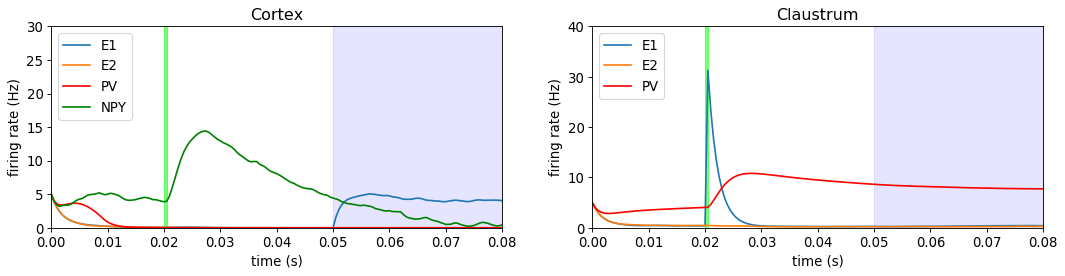

In [62]:
model_0 = Model(p_0)
model_0.run()
fig = model_0.draw()

# Fine tuning to get persistent activity

In [ ]:
def fine_tuning(parameter,par_list = np.arange(0,0.5,0.1)):
    for p, par in enumerate(par_list):
        print('g_E_self =', par)
        p_1 = p_0.copy()
        p_1.update({'g_E_self': par * brian2.nA})
        J =  np.array([[p_0['g_E_self']    , p_0['g_E_cross'], p_0['g_I_E']],
              [p_0['g_E_cross']    , p_0['g_E_self'],  p_0['g_I_E']],
               [p_0['g_E_I'],p_0['g_E_I'],p_0['g_Iself'] ]]).T * brian2.amp
        J_NMDA = J*((J>0).astype(np.int))
        J_GABA = J*((J<0).astype(np.int))
        model_1 = Model(p_1)
        model_1.run()
        fig = model_1.draw()
    return 
  

g_E_self = 0.48
rate PV and NPY (Cortex): [5. 5.] Hz
rate PV and NPY (Claustrum): [5. 5.] Hz
rate PV and NPY (Cortex): [3.29652535 0.07538697] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29652535 0.07538698] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [4.96415590e-65 7.07642898e-85] yHz
rate PV and NPY (Claustrum): [2.92665188e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.87651324e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.89184948e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29609498 0.0801557 ] Hz
rate PV and NPY (Claustrum): [3.29151194e-06 0.00000000e+00] MHz


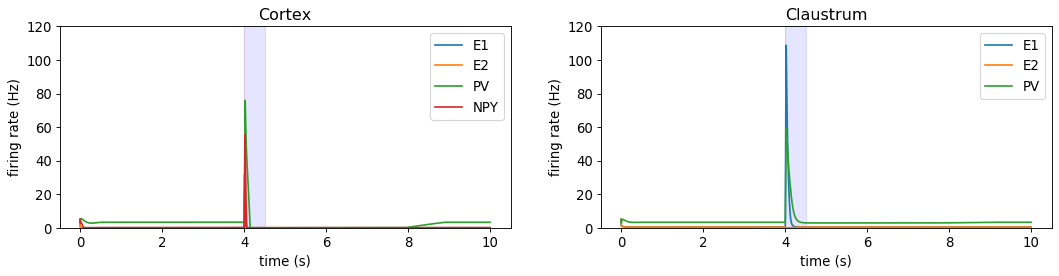

g_E_self = 0.5
rate PV and NPY (Cortex): [5. 5.] Hz
rate PV and NPY (Claustrum): [5. 5.] Hz
rate PV and NPY (Cortex): [3.29652535 0.07538697] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29652535 0.07538698] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [4.96415590e-65 7.07642898e-85] yHz
rate PV and NPY (Claustrum): [2.92665188e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.87651324e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.89184948e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29609498 0.0801557 ] Hz
rate PV and NPY (Claustrum): [3.29151194e-06 0.00000000e+00] MHz


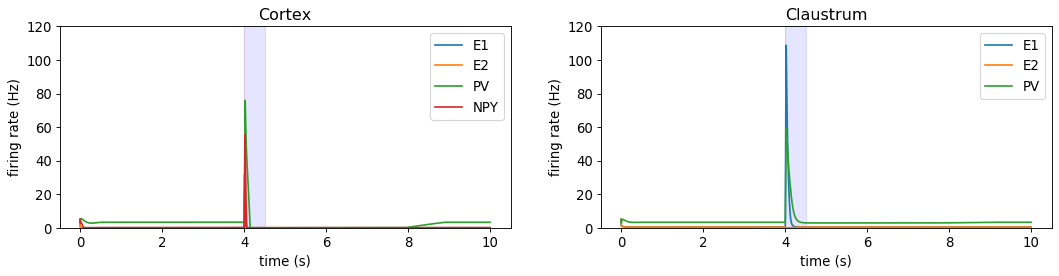

g_E_self = 0.52
rate PV and NPY (Cortex): [5. 5.] Hz
rate PV and NPY (Claustrum): [5. 5.] Hz
rate PV and NPY (Cortex): [3.29652535 0.07538697] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29652535 0.07538698] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [4.96415590e-65 7.07642898e-85] yHz
rate PV and NPY (Claustrum): [2.92665188e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.87651324e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.89184948e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29609498 0.0801557 ] Hz
rate PV and NPY (Claustrum): [3.29151194e-06 0.00000000e+00] MHz


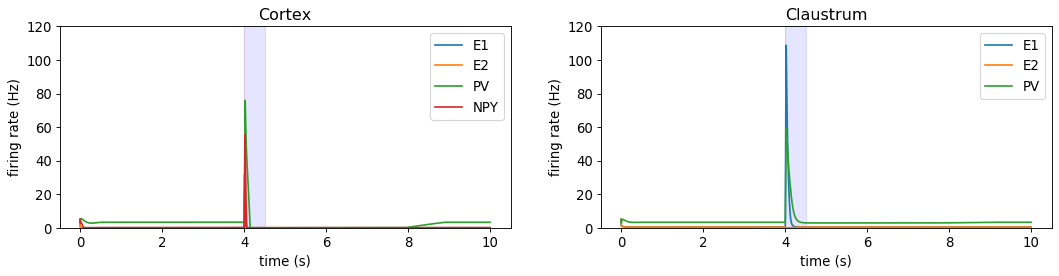

g_E_self = 0.54
rate PV and NPY (Cortex): [5. 5.] Hz
rate PV and NPY (Claustrum): [5. 5.] Hz
rate PV and NPY (Cortex): [3.29652535 0.07538697] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29652535 0.07538698] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [4.96415590e-65 7.07642898e-85] yHz
rate PV and NPY (Claustrum): [2.92665188e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.87651324e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.89184948e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29609498 0.0801557 ] Hz
rate PV and NPY (Claustrum): [3.29151194e-06 0.00000000e+00] MHz


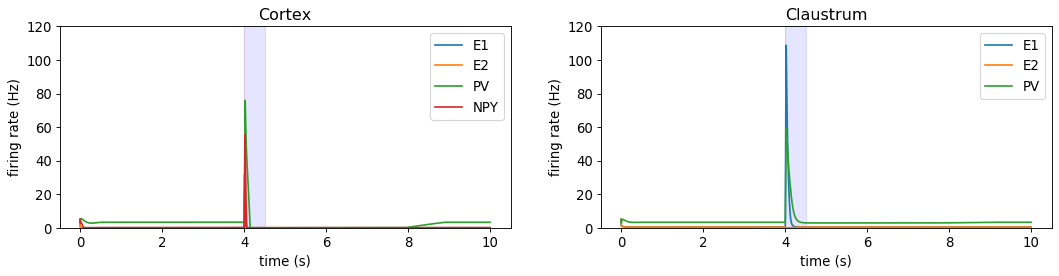

g_E_self = 0.56
rate PV and NPY (Cortex): [5. 5.] Hz
rate PV and NPY (Claustrum): [5. 5.] Hz
rate PV and NPY (Cortex): [3.29652535 0.07538697] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29652535 0.07538698] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [4.96415590e-65 7.07642898e-85] yHz
rate PV and NPY (Claustrum): [2.92665188e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.87651324e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.89184948e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29609498 0.0801557 ] Hz
rate PV and NPY (Claustrum): [3.29151194e-06 0.00000000e+00] MHz


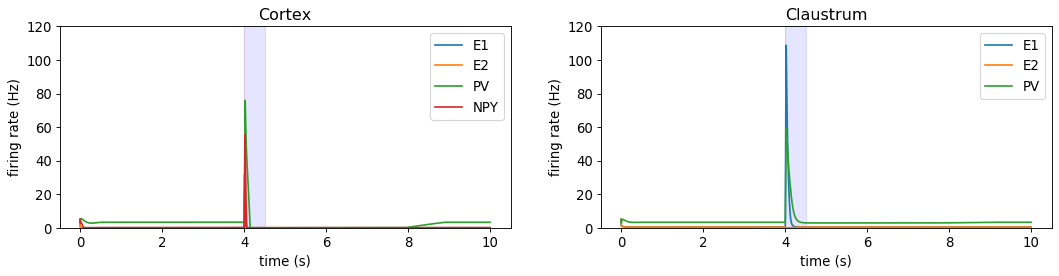

g_E_self = 0.5800000000000001
rate PV and NPY (Cortex): [5. 5.] Hz
rate PV and NPY (Claustrum): [5. 5.] Hz
rate PV and NPY (Cortex): [3.29652535 0.07538697] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29652535 0.07538698] Hz
rate PV and NPY (Claustrum): [3.29305672e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [4.96415590e-65 7.07642898e-85] yHz
rate PV and NPY (Claustrum): [2.92665188e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.87651324e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [0. 0.] YHz
rate PV and NPY (Claustrum): [2.89184948e-06 0.00000000e+00] MHz
rate PV and NPY (Cortex): [3.29609498 0.0801557 ] Hz
rate PV and NPY (Claustrum): [3.29151194e-06 0.00000000e+00] MHz


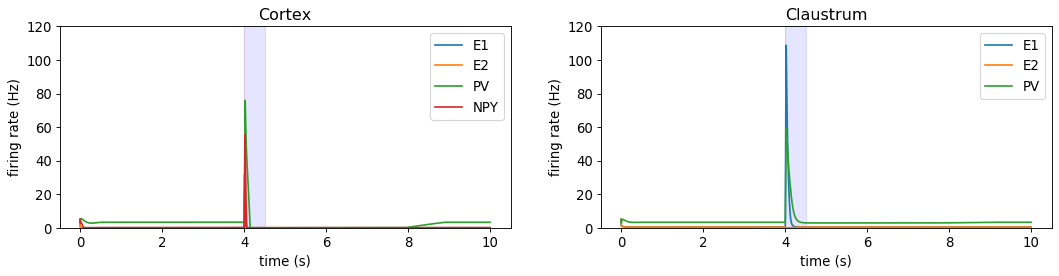

In [202]:
l = np.arange(0.48,0.60,0.02)

fine_tuning(p_0,l)

# Steady states

In [203]:
area_list = ['Local']

In [21]:
def steady_state_firing_rate(p):
    model = Model(p)
    model.run()   
    steady_FR = model.R[-1,:,:] # steady state activity rate
    #if want to take the mean
    # l =[]
    # for i in range(100):
    # model.run()
    # l.append(model.R[-1,:,:])
    #stead_FR = np.mean(l)
    return steady_FR

In [22]:
def st_FR_diff_strength(parameter,stim_list = np.arange(0,0.1,0.02)):
    steady_state_firing_rate_list = np.zeros((len(stim_list),1,3)) #UPDATE HERE
    for a, alpha in enumerate(stim_list):
        print('stim =', alpha)
        p = parameter.copy()
        p.update({'dist_strength': alpha * brian2.nA})
        steady_FR = steady_state_firing_rate(p)
        steady_state_firing_rate_list[a,:,:] = steady_FR #UPDATE HERE

    return steady_state_firing_rate_list

In [ ]:
#good for different areas
def plot_st_FR_strength(stage,steady_state_firing_rate_list,stim_list):
    plt.rcParams.update({'font.size': 20})

    # generate dataframe
    df_st_FR_E1 = pandas.DataFrame(steady_state_firing_rate_list[:,:,0], columns = area_list)
    df_st_FR_E2 = pandas.DataFrame(steady_state_firing_rate_list[:,:,1], columns = area_list)
    df_st_FR_I  = pandas.DataFrame(steady_state_firing_rate_list[:,:,2], columns = area_list)
  
    
    fig = plt.figure(figsize = (25,16))
    for a, alpha in enumerate(stim_list):
        plt.plot(df_st_FR_E1.iloc[a,:],label= "Stimulation strength =  %.3f".format(alpha), c = cm.Blues(50+a*30), linewidth = 5)

    plt.xticks(rotation=90)
    plt.ylabel('Steady state firing rate (Hz)')
    plt.legend()

    for alpha in range(0,len(df_st_FR_E1)):
        plt.scatter(np.arange(0,40),df_st_FR_E1.iloc[alpha,:],s = 80,c = cm.Blues(50+alpha*30))

    plt.show()
    return fig

In [45]:
stim_list = np.arange(0.08,0.10,0.005)

df_st_FR = st_FR_diff_strength(p_0,stim_list)

stim = 0.08
stim = 0.085
stim = 0.09000000000000001
stim = 0.09500000000000001
stim = 0.10000000000000002


In [46]:
def plot_st_FR_E1(df_st_FR, stim_list):
    
    fig = plt.figure(figsize = (5,5))
    df_st_FR_E1 = pandas.DataFrame(df_st_FR[:,:,0])
    plt.plot(stim_list,df_st_FR_E1, linewidth=0, marker='x')
    plt.xlabel('Distr_strength (nA)')
    plt.ylabel('E1 FR (Hz)')
    plt.show()
    return fig

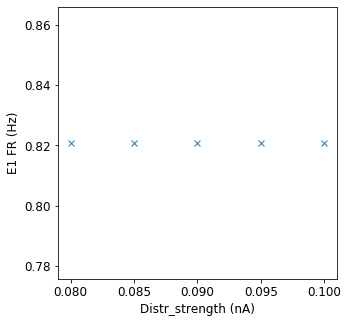

In [47]:
fig = plot_st_FR_E1(df_st_FR, stim_list)

### Add distraction

In [ ]:
def st_FR_diff_strength_dist(parameter,stim_list = np.arange(0.03,0.12,0.03), dist_list=np.arange(0,0.3,0.1)):
    steady_state_firing_rate_list = np.zeros((len(dist_list),len(stim_list),3)) #UPDATE HERE
    for d, delta in enumerate(dist_list):
        print('dist_strength = ', delta)
        p = parameter.copy()
        p.update({'dist_strength' : delta * brian2.nA})
        print(p['dist_strength'])
        for a, alpha in enumerate(stim_list):
            print('stim =', alpha)
            p.update({'stim_strength': alpha * brian2.nA})
            steady_FR = steady_state_firing_rate(p)
            steady_state_firing_rate_list[d,a,:] = steady_FR #UPDATE HERE
    return steady_state_firing_rate_list

In [ ]:
stim_list = np.arange(0.03,0.12,0.03)
dist_list = np.arange(0,0.2,0.05)

df_st_FR = st_FR_diff_strength_dist(p_0,stim_list, dist_list)

In [ ]:
df_st_FR


In [ ]:
def plot_FR_diff_strength_dist_E1(df_st_FR, stim_list, dist_list):
    fig = plt.figure(figsize = (10,10))
    for i in range(len(dist_list)):
        df_st_dist_E1 = pandas.DataFrame(df_st_FR[i,:,0])
        plt.plot(stim_list,df_st_dist_E1, linewidth=0, marker='o')
        plt.xlabel('I_ext (nA)')
        plt.ylabel('E1 FR (Hz)')
    plt.legend(dist_list)
    plt.show()
    return 

In [ ]:
plot_FR_diff_strength_dist_E1(df_st_FR, stim_list,dist_list)

# Fine-tuning to get robust regime

In [ ]:
parameters.update({   
                    # Strength of connections from E cells
                    'g_E_self': 0.48 * brian2.nA ,        # nA --> I_local_grad_NMDA
                    'g_E_cross': 0.0107* brian2.nA,         # nA --> J_NMDA --> I_local_nongrad_NMDA
                    # Strength of connections from I cells
                    'g_E_I':  -0.31   * brian2.nA,         # nA --> J_GABA --> I_local_GABA
                    'g_Iself': -0.12  * brian2.nA,         # nA --> J_GABA --> I_local_GABA
                    'g_I_E': 233 * brian2.pA,               #pA
                        }) 

In [ ]:
def st_FR_diff_strength(parameter,par_list = np.arange(0,0.1,0.02)):
    steady_state_firing_rate_list = np.zeros((len(par_list),1,3)) #UPDATE HERE
    for a, alpha in enumerate(par_list):
        print('par =', alpha)
        p = parameter.copy()
        p.update({'g_E_self': alpha * brian2.nA})
        J =  np.array([[p['g_E_self']    , p['g_E_cross'], p['g_I_E']],
              [p['g_E_cross']    , p['g_E_self'],  p['g_I_E']],
               [p['g_E_I'],p['g_E_I'],p['g_Iself'] ]]).T * brian2.amp
        J_NMDA = J*((J>0).astype(np.int))
        J_GABA = J*((J<0).astype(np.int))
        steady_FR = steady_state_firing_rate(p) #run model here
        steady_state_firing_rate_list[a,:,:] = steady_FR #UPDATE HERE
    return steady_state_firing_rate_list

In [ ]:
par_list = np.arange(0.09,0.12,0.005)

df_st_FR = st_FR_diff_strength(p_0,par_list)